In [1]:
import pandas as pd
from datetime import datetime, timedelta 
from glob import glob
#for graphing data and predictions
from utils import plot_prediction_validation
#for plotting confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, precision_score, accuracy_score

In [2]:
#get theif hatch pressure data
df_thp = []
for f in glob('data/tank_header_pressure_*.csv'):
    df_thp.append(pd.read_csv(f))
df_thp = pd.concat(df_thp)
df_thp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2246256 entries, 0 to 246255
Data columns (total 4 columns):
 #   Column        Dtype  
---  ------        -----  
 0   timestamp     object 
 1   TagType       object 
 2   FACILITY_ID   int64  
 3   pressure_osi  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 85.7+ MB


In [3]:
#get data for specific facility id
facility_id = 10085460
df_thp_460 = df_thp[df_thp.FACILITY_ID == facility_id].copy()
df_thp_460.timestamp = pd.to_datetime(df_thp_460.timestamp)

In [4]:
#get data within datarange (for speed and readability)
t_check = "2022-08-19 12:00:00.000"
t_check = pd.to_datetime(t_check)
t_strt = t_check - timedelta(days=60) #start 60 days before date of interest
t_stop = t_check + timedelta(days=30) #stop 30 days after date of interest

df_thp_460 = df_thp_460[df_thp_460.timestamp.between(t_strt, t_stop)]

In [5]:
from models import model_ground_truth, model_predict_open_hatch

df = df_thp_460.copy()
pred_freq = timedelta(hours=12) # Predict every 12 hours

#start at the nearest hour
t_strt = df.timestamp.iloc[0]
t_strt = datetime(*t_strt.timetuple()[:4])
t_strt += pred_freq 
t_strt_0 = t_strt

#end at the nearest hour
t_stop = df.timestamp.iloc[-1]
t_stop = datetime(*t_stop.timetuple()[:4])
t_stop -= pred_freq 

df_pred = []
while t_strt <= t_stop:
    
    #add a new datapoint with prediction
    df_pred.append([t_strt, model_ground_truth(df, t_strt)] + model_predict_open_hatch(df, t_strt))

    t_strt += pred_freq

#write data to a dataframe
df_pred = pd.DataFrame(df_pred, columns = ['TimeStamp', 'Status_Truth', 'Status_Predicted', 'Probability_Open_Hatch'])

#note: this might take up to a minute

1/1 [==============================] - 0s 33ms/step


In [6]:
#plot data, truth, prediction, and confidence
fig = plot_prediction_validation(df, df_pred, facility_id)
fig.show()

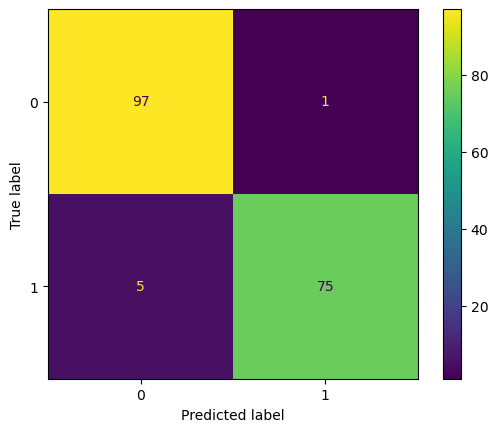

In [7]:
# calculate confusion matrix of known data
conf_matrix = confusion_matrix(df_pred.Status_Truth, df_pred.Status_Predicted)
ConfusionMatrixDisplay(conf_matrix).plot()